 https://drive.google.com/file/d/1yoipf6FsSo-eYpiI2i3qIL2SARZuXU3J/view?usp=sharing
 Почему-то проблемы с сервером, не могу скачать пдф, тут есть html копия


In [18]:
from scipy import linalg
import glob
from numpy import *
import scipy
from scipy import fftpack
from scipy.signal import butter, lfilter, hilbert
import scipy.interpolate
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import gc
import sys
import os
import os.path, time
import csv
import mne
from mne import io
from mne.connectivity import spectral_connectivity
from mne.viz import circular_layout, plot_connectivity_circle
from mne.viz import plot_sensors_connectivity
import biosppy
import numpy as np
import pyhrv.tools as tools
import pyhrv.time_domain as td 
import pyhrv.frequency_domain as fd
import pyhrv.nonlinear as nl
from opensignalsreader import OpenSignalsReader


In [7]:
signal_1 = OpenSignalsReader('subject_1.txt').signal('ECG')
signal_2 = OpenSignalsReader('subject_2.txt').signal('ECG')
signal_3 = OpenSignalsReader('subject_3.txt').signal('ECG')
signal_4 = OpenSignalsReader('subject_4.txt').signal('ECG')

signal_1, rpeaks_1 = biosppy.signals.ecg.ecg(signal_1, show=False)[1:3]
signal_2, rpeaks_2 = biosppy.signals.ecg.ecg(signal_2, show=False)[1:3]
signal_3, rpeaks_3 = biosppy.signals.ecg.ecg(signal_3, show=False)[1:3]
signal_4, rpeaks_4 = biosppy.signals.ecg.ecg(signal_4, show=False)[1:3]


nni_1 = tools.nn_intervals(rpeaks_1)
nni_2 = tools.nn_intervals(rpeaks_2)
nni_3 = tools.nn_intervals(rpeaks_3)
nni_4 = tools.nn_intervals(rpeaks_4)

## Визуализация данных ЭКГ

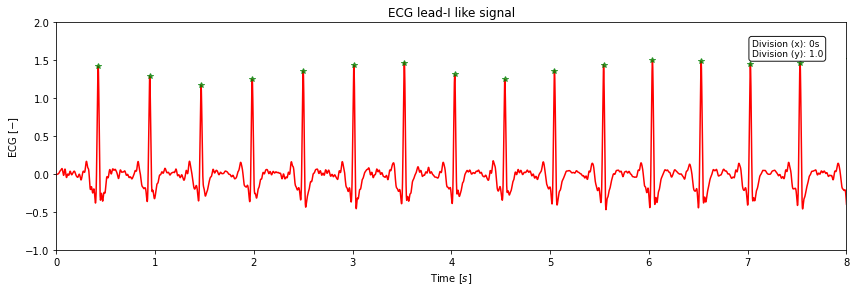

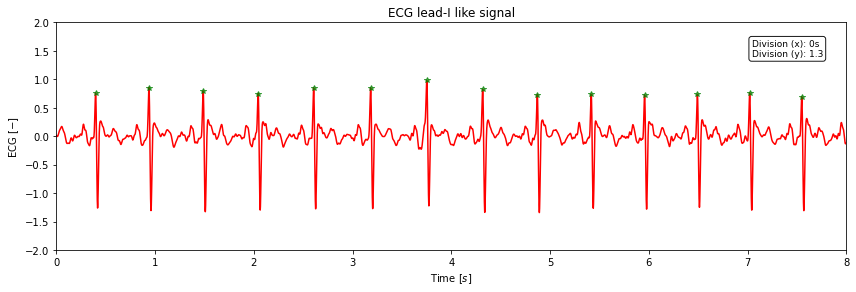

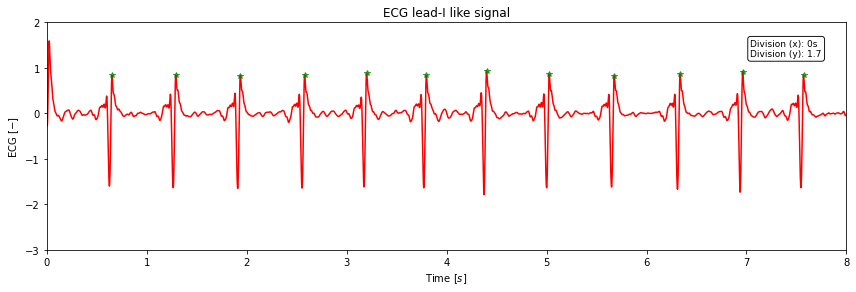

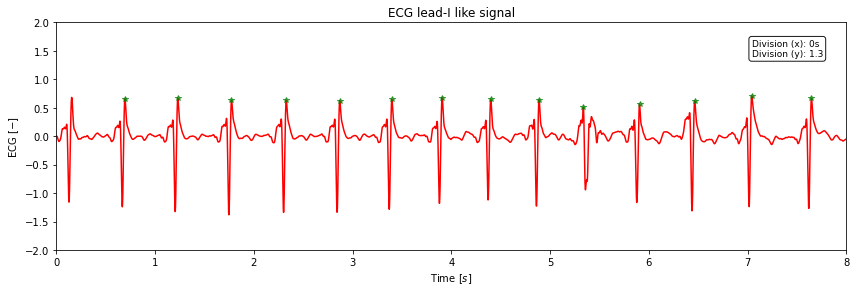

ReturnTuple(ecg_plot=<Figure size 864x288 with 1 Axes>)

In [8]:
# Plot the ECG signal (interval: 0s to 15s)
tools.plot_ecg(signal_1, interval=[0, 8])
tools.plot_ecg(signal_2, interval=[0, 8])
tools.plot_ecg(signal_3, interval=[0, 8])
tools.plot_ecg(signal_4, interval=[0, 8])


Можно заметить, что 2,3 и 4 графики инвертированны(верхний - R- пик должен быть больше). Поэтому:

In [9]:
signal_1, rpeaks_1 = biosppy.signals.ecg.ecg(signal_1, show=False)[1:3]
signal_2, rpeaks_2 = biosppy.signals.ecg.ecg(signal_2*(-1), show=False)[1:3]
signal_3, rpeaks_3 = biosppy.signals.ecg.ecg(signal_3*(-1), show=False)[1:3]
signal_4, rpeaks_4 = biosppy.signals.ecg.ecg(signal_4*(-1), show=False)[1:3]


nni_1 = tools.nn_intervals(rpeaks_1)
nni_2 = tools.nn_intervals(rpeaks_2)
nni_3 = tools.nn_intervals(rpeaks_3)
nni_4 = tools.nn_intervals(rpeaks_4)

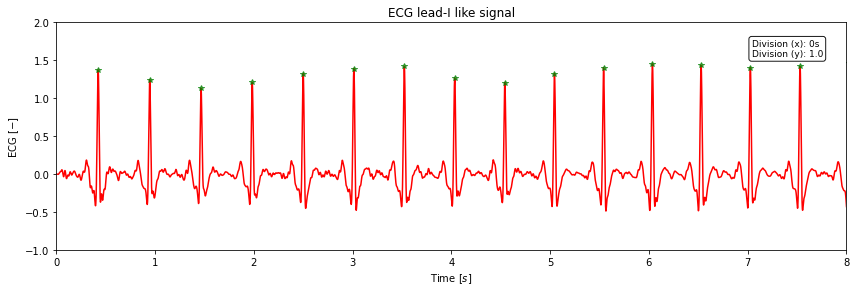

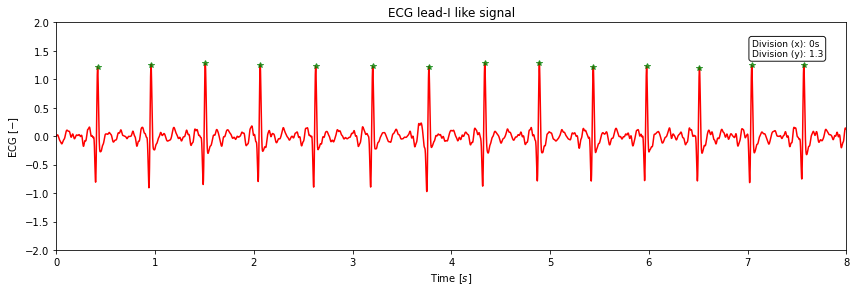

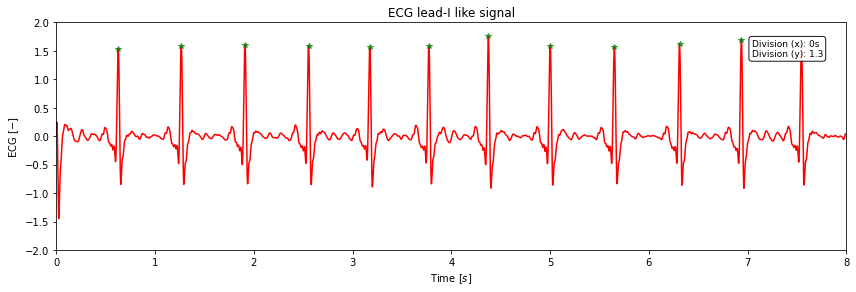

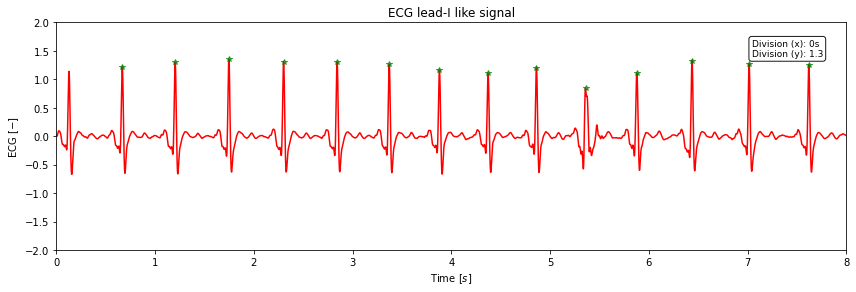

ReturnTuple(ecg_plot=<Figure size 864x288 with 1 Axes>)

In [10]:
tools.plot_ecg(signal_1, interval=[0, 8])
tools.plot_ecg(signal_2, interval=[0, 8])
tools.plot_ecg(signal_3, interval=[0, 8])
tools.plot_ecg(signal_4, interval=[0, 8])

Теперь правильно! Задача данной работы - определить, какой из испытуемых "наиболее здоровый".
Определим это, сравнивая показатели, описанные в статье https://vc.ru/tech/121021-kak-rasschityvayutsya-pokazateli-stressa-i-energii-v-fitnes-gadzhetah-analiz-variabelnosti-serdechnogo-ritma
А именно:
RMSSD - Root Mean Square of Successive Differences.Он показывает состояние парасимпатической системы, отвечающей за восстановление организма после стресса. Высокий RMSSD говорит о высокой степени восстановления организма и его готовности к очередным и большим нагрузкам.
Вегетативный баланс LF/HF - отражает сбалансированность симпатической (стресс) и парасимпатической (восстановление) систем.
Значения данного показатель в диапазоне (0.3, 0.7) - хорошо, (0.7, 2) - еще лучше!
Кроме того, показатель HF не должен быть слишком низким

# Считаем RMSSD

21.6473852517634
37.98266104003957
50.05387651363059
55.27486745477788


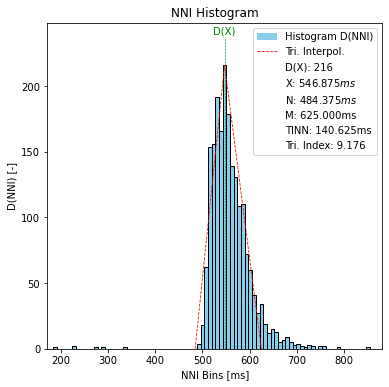

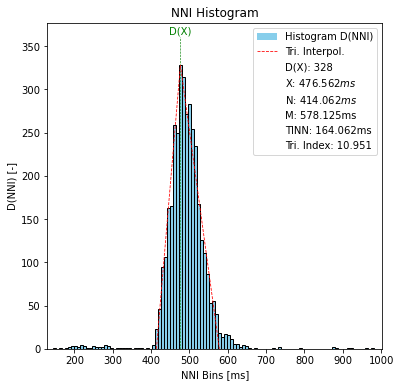

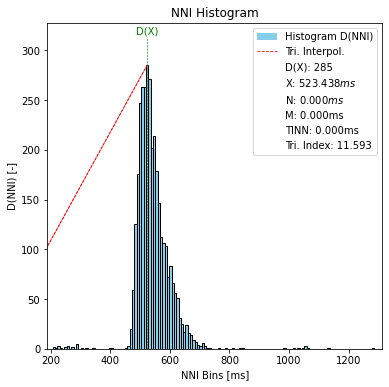

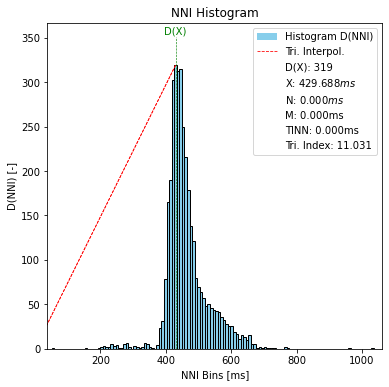

In [12]:

result_1 = td.time_domain(nni_1)
print(result_1['rmssd'])

result_2 = td.time_domain(nni_2)
print(result_2['rmssd'])

result_3 = td.time_domain(nni_3)
print(result_3['rmssd'])

result_4 = td.time_domain(nni_4)
print(result_4['rmssd'])

## Микровывод:
У испытуемых 3 и 4 выше показатель RMSSD => можно предположить, что их организм бстрее восстанавливается после болезни или сильного стресса.

## Теперь обработка спекральной плотности мощности


Используем метод Уэлча.

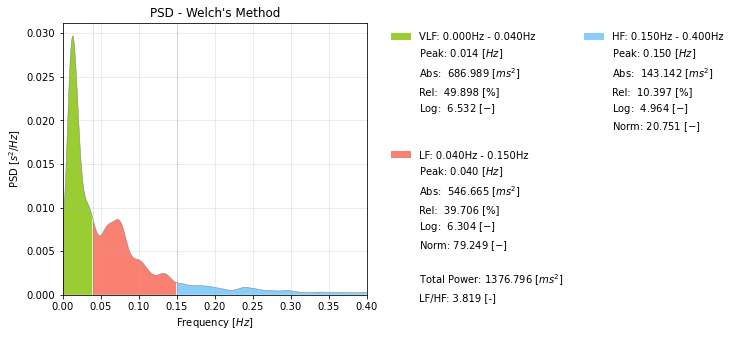

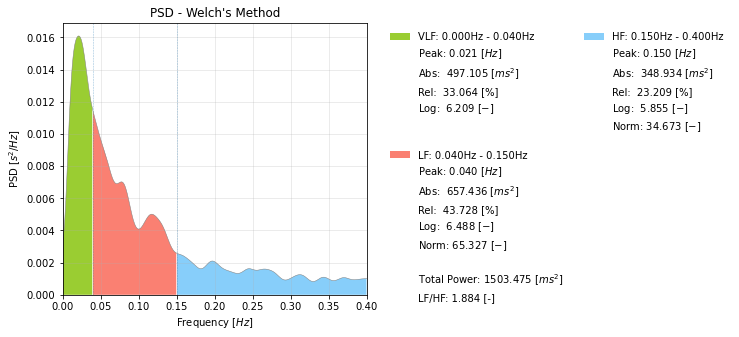

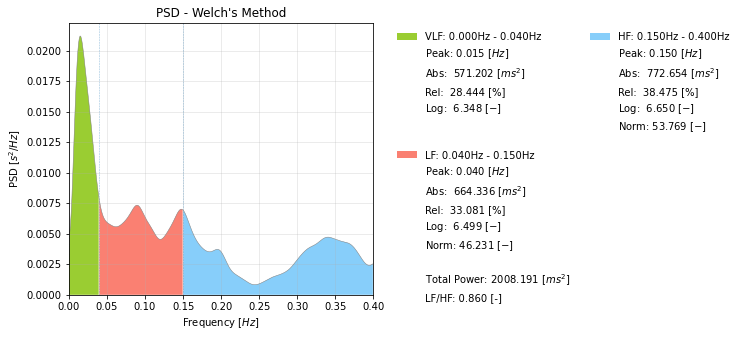

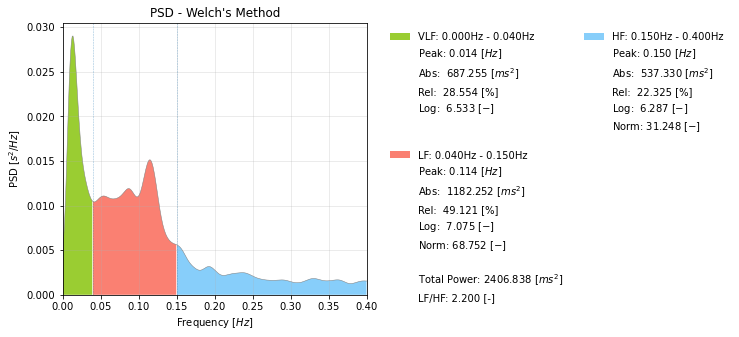

In [14]:
result_psd_1 = fd.welch_psd(nni=nni_1)
result_psd_2 = fd.welch_psd(nni=nni_2)
result_psd_3 = fd.welch_psd(nni=nni_3)
result_psd_4 = fd.welch_psd(nni=nni_4)

## Микровывод:
Вегетативный баланс. Норма: 0.3 - 2, лучше, если в пределах 0.7 - 2
Испытуемый 1 - отклонение от нормы. Высокий показатель VLF по сравнению с друими показателями - видимо испытуемый находится в состоянии сильного стресса, происходит гуморальная регуляция организма. Об этом также может свидетельствовать низкий показатель TP
Испытуемые 2, 3 - норма, но у второго низкий показатель HF
Испытуемый 4 - небольшое отклонение от нормы в большую сторону, возможно испытемый находится в состоянии небольшого стресса(показатель LF также довольно высокий, а HF низкий по сравнению с отсальными учаастниками).


## Графики Пуанкаре

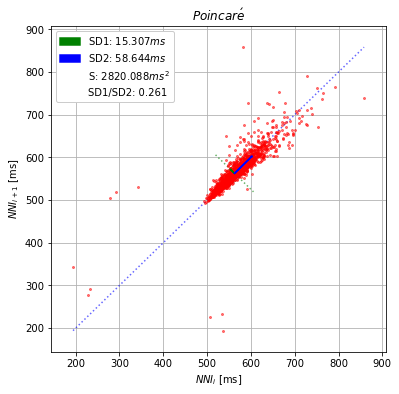

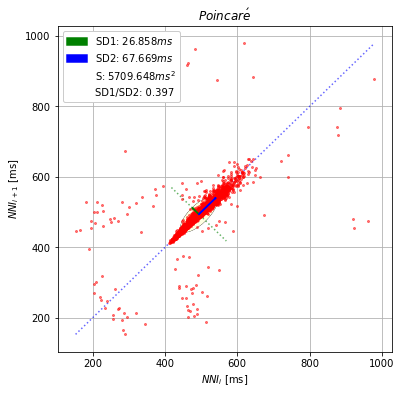

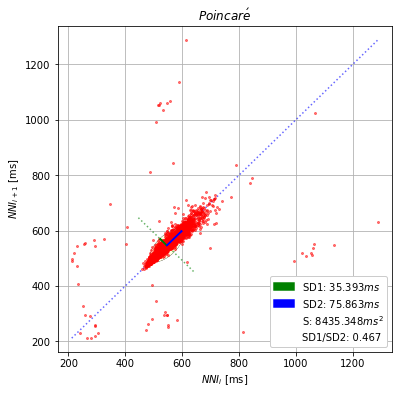

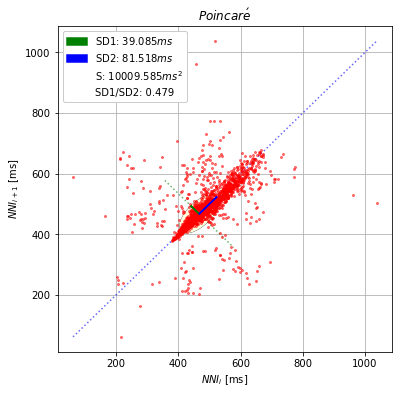

In [22]:
import pyhrv.nonlinear as nl
result_pc_1 = nl.poincare(nni_1)
result_pc_2 = nl.poincare(nni_2)
result_pc_3 = nl.poincare(nni_3)
result_pc_4 = nl.poincare(nni_4)

Посчитаем площадь "облаков Пуанкаре"


In [26]:

print('1: ', result_pc_1['sd1']*result_pc_1['sd2'] )

print('2: ', result_pc_2['sd1']*result_pc_2['sd2'] )

print('3: ', result_pc_3['sd1']*result_pc_3['sd2'] )

print('4: ', result_pc_4['sd1']*result_pc_4['sd2'] )


1:  897.6620103688665
2:  1817.437313391644
3:  2685.0546755602263
4:  3186.1499458734374


## Анализ графиков
Все графики симметричны, что говорит об отсутствии у испытуемых серьезных нарушений ритма.
Форма облака (подробнее и примеры картинок тут https://files.btlnet.com/product-document/e1b30259-87f2-4e7f-af11-97fdb027a9c0/BTL-Cardiopoint_WP_Poincare-graph_RU400_e1b30259-87f2-4e7f-af11-97fdb027a9c0_original.pdf и здесь https://publications.waset.org/10002615/pdf)

Сжатое «облако»: превышение длины эллипса
над шириной (преобладание симпат. отдела ВНС в
формировании общей ВСР).
 Большое «облако»: длина и ширина эллипса примерно
равны (преобладание парасимпат. отдела ВНС).
Похоже, что у первого и второго преобладает симпатический отдел - совпадает с предыдущими результатми.
Площадь облака у первого испытуемого заметно ниже, чем у остальных, что считается плохим показателем.

## Вывод:
На основе изученных параметров мжно предположить, что "наиболее здоровым" является третий испытуемый.